In [1]:
import pandas as pd
import numpy as np
import src.scripts as src
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, \
                            recall_score, accuracy_score, precision_score, confusion_matrix, \
                            f1_score, roc_auc_score

In [18]:
def run_random_forest(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
    
    clf = RandomForestClassifier(n_jobs=-1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_test, y_pred

def plot_roc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # method I: plt
    plt.title('Random Forest Classification')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def random_sample(size=1000000, minority_ratio=0.3):
    # Isolate minority & majority class
    minority = df[df['exclusion'] == True].reset_index(drop=True)
    majority = df[df['exclusion'] != True].reset_index(drop=True)


    minority_idx = np.random.randint(low=0,high=minority.shape[0], size=round(size*minority_ratio))
    majority_idx = np.random.randint(low=0,high=majority.shape[0], size=round(size*(1-minority_ratio)))
    
    over_samp = minority.iloc[minority_idx]
    under_samp = majority.iloc[majority_idx]
    
    df_adj = pd.concat([over_samp, under_samp], axis=0).reset_index(drop=True)
    y_adj = df_adj['exclusion']
    X_adj = pd.get_dummies(df_adj.drop(columns=['nppes_provider_state','npi','exclusion'], axis=0), columns=['generic_name'])
    
    return X_adj, y_adj

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

def conf_mat(y_test, y_pred):
    y_test = pd.Series(y_test, name='Actual')
    y_pred = pd.Series(y_pred, name='Predicted')
    return pd.crosstab(y_test, y_pred, ).T

In [3]:
# real data
df = src.read_from_efs('X_reduced.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Actual      False  True 
Predicted               
False      104567    368
True            2      0


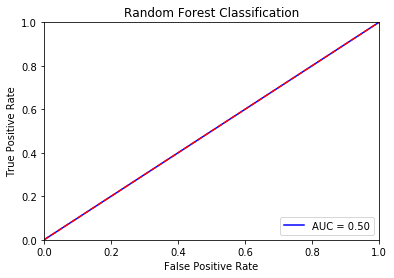

In [21]:
y = df['exclusion']
X = pd.get_dummies(df.drop(columns=['nppes_provider_state','npi','exclusion'], axis=0), columns=['generic_name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)  
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(conf_mat(y_test, y_pred))
plot_roc(y_test, y_pred)

Actual     False  True 
Predicted              
False      37919   1989
True         222     11


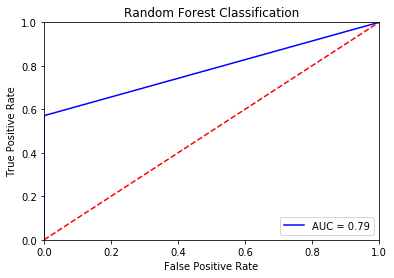

In [26]:
# data w/ sampling
X_adj, y_adj = random_sample(size=1000000, minority_ratio=.01)

X_train, X_test, y_train, y_test = train_test_split(X_adj, y_adj, test_size=.2, stratify=y_adj)  
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(conf_mat(y_test, y_pred))
plot_roc(y_test, y_pred)

In [ ]:
# perfrom grid search
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'roc_auc_score': make_scorer(roc_auc_score)
}

grid_search_wrapper(refit_score='recall_score')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, wa